## imports for Python, Pandas

In [224]:
from collections import Counter, defaultdict

import pandas as pd
import json
from pandas.io.json import json_normalize

****
## JSON World Bank Dataset Exercise

To better appreciate Pandas' JSON loading abilities, I decided to first solve the following three problems without using `json_normalize`, which entails quasi-baroque dictionary storage and manipulation. After this, I use `json_normalize` to solve the same three problems:
1. Find the 10 countries with most projects
2. Find the top 10 major project themes (using column 'mjtheme_namecode')
3. In 2. above you will notice that some entries have only the code and the name is missing. Create a dataframe with the missing names filled in.

In [225]:
# load as Pandas dataframe to see what columns are named but otherwise avoid json normalization
pd.set_option('display.max_columns', 200)
json_df = pd.read_json('data/world_bank_projects.json')
json_df.head()

,_id,approvalfy,board_approval_month,boardapprovaldate,borrower,closingdate,country_namecode,countrycode,countryname,countryshortname,docty,envassesmentcategorycode,grantamt,ibrdcommamt,id,idacommamt,impagency,lendinginstr,lendinginstrtype,lendprojectcost,majorsector_percent,mjsector_namecode,mjtheme,mjtheme_namecode,mjthemecode,prodline,prodlinetext,productlinetype,project_abstract,project_name,projectdocs,projectfinancialtype,projectstatusdisplay,regionname,sector,sector1,sector2,sector3,sector4,sector_namecode,sectorcode,source,status,supplementprojectflg,theme1,theme_namecode,themecode,totalamt,totalcommamt,url
0,{'$oid': '52b213b38594d8a2be17c780'},1999,November,2013-11-12T00:00:00Z,FEDERAL DEMOCRATIC REPUBLIC OF ETHIOPIA,2018-07-07T00:00:00Z,Federal Democratic Republic of Ethiopia!$!ET,ET,Federal Democratic Republic of Ethiopia,Ethiopia,"Project Information Document,Indigenous People...",C,0,0,P129828,130000000,MINISTRY OF EDUCATION,Investment Project Financing,IN,550000000,"[{'Percent': 46, 'Name': 'Education'}, {'Perce...","[{'code': 'EX', 'name': 'Education'}, {'code':...",[Human development],"[{'code': '8', 'name': 'Human development'}, {...","8,11",PE,IBRD/IDA,L,{'cdata': 'The development objective of the Se...,Ethiopia General Education Quality Improvement...,"[{'DocDate': '28-AUG-2013', 'EntityID': '09022...",IDA,Active,Africa,"[{'Name': 'Primary education'}, {'Name': 'Seco...","{'Percent': 46, 'Name': 'Primary education'}","{'Percent': 26, 'Name': 'Secondary education'}","{'Percent': 16, 'Name': 'Public administration...","{'Percent': 12, 'Name': 'Tertiary education'}","[{'code': 'EP', 'name': 'Primary education'}, ...","ET,BS,ES,EP",IBRD,Active,N,"{'Percent': 100, 'Name': 'Education for all'}","[{'code': '65', 'name': 'Education for all'}]",65,130000000,130000000,http://www.worldbank.org/projects/P129828/ethi...
1,{'$oid': '52b213b38594d8a2be17c781'},2015,November,2013-11-04T00:00:00Z,GOVERNMENT OF TUNISIA,NaN,Republic of Tunisia!$!TN,TN,Republic of Tunisia,Tunisia,"Project Information Document,Integrated Safegu...",C,4700000,0,P144674,0,MINISTRY OF FINANCE,Specific Investment Loan,IN,5700000,"[{'Percent': 70, 'Name': 'Public Administratio...","[{'code': 'BX', 'name': 'Public Administration...","[Economic management, Social protection and ri...","[{'code': '1', 'name': 'Economic management'},...","1,6",RE,Recipient Executed Activities,L,NaN,TN: DTF Social Protection Reforms Support,"[{'DocDate': '29-MAR-2013', 'EntityID': '00033...",OTHER,Active,Middle East and North Africa,[{'Name': 'Public administration- Other social...,"{'Percent': 70, 'Name': 'Public administration...","{'Percent': 30, 'Name': 'General public admini...",NaN,NaN,"[{'code': 'BS', 'name': 'Public administration...","BZ,BS",IBRD,Active,N,"{'Percent': 30, 'Name': 'Other economic manage...","[{'code': '24', 'name': 'Other economic manage...","54,24",0,4700000,http://www.worldbank.org/projects/P144674?lang=en
2,{'$oid': '52b213b38594d8a2be17c782'},2014,November,2013-11-01T00:00:00Z,MINISTRY OF FINANCE AND ECONOMIC DEVEL,NaN,Tuvalu!$!TV,TV,Tuvalu,Tuvalu,"Resettlement Plan,Environmental Assessment,Int...",B,0,0,P145310,6060000,MINISTRY OF TRANSPORT AND COMMUNICATIONS,Investment Project Financing,IN,6060000,"[{'Percent': 100, 'Name': 'Transportation'}]","[{'code': 'TX', 'name': 'Transportation'}]","[Trade and integration, Public sector governan...","[{'code': '5', 'name': 'Trade and integration'...","5,2,11,6",PE,IBRD/IDA,L,NaN,Tuvalu Aviation Investment Project - Additiona...,"[{'DocDate': '21-OCT-2013', 'EntityID': '00033...",IDA,Active,East Asia and Pacific,[{'Name': 'Rural and Inter-Urban Roads and Hig...,"{'Percent': 100, 'Name': 'Rural and Inter-Urba...",NaN,NaN,NaN,"[{'code': 'TI', 'name': 'Rural and Inter-Urban...",TI,IBRD,Active,Y,"{'Percent': 46, 'Name': 'Regional integration'}","[{'code': '47', 'name': 'Regional integration'...","52,81,25,47",6060000,6060000,http://www.worldbank.org/projects/P145310?lang=en
3,{'$oid': '52b213b38594d8a2be17

## 1. Which ten countries are hosting the most projects?

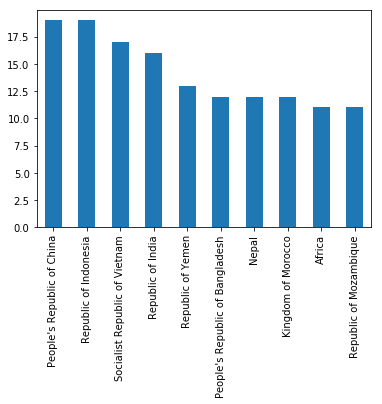

In [226]:
%matplotlib inline
df = json_df
df.countryname.value_counts().head(10).plot(kind='bar')

(Africa is problematically listed as a country, but there's not an obvious way to recover country by country information.)

## 2. What are the top ten project themes?:

It looks like each row contains several theme codes, and the value of the column is a list of dictionaries:

In [227]:
df = json_df
df['mjtheme_namecode'].get(2)

[{'code': '5', 'name': 'Trade and integration'},
 {'code': '2', 'name': 'Public sector governance'},
 {'code': '11', 'name': 'Environment and natural resources management'},
 {'code': '6', 'name': 'Social protection and risk management'}]

To count up the theme instances, we can define a function to iterate through each dictionary's theme names and append them to a global list.

In [228]:
theme_name_list = []
def count_list_of_dicts(list_of_dicts):
    """counts up instances of theme codes and stores the count in a global dictionary"""
    for d in list_of_dicts:
        theme_name_list.append(d['name'])

Then we can apply the function to the dataframe column using `apply`, after which we can use a `Counter` to count up the ten most common themes in our theme_name_list.

In [229]:
df = json_df
df['mjtheme_namecode'].apply(count_list_of_dicts)
c = Counter(theme_name_list).most_common(10)
c

[('Environment and natural resources management', 223),
 ('Rural development', 202),
 ('Human development', 197),
 ('Public sector governance', 184),
 ('Social protection and risk management', 158),
 ('Financial and private sector development', 130),
 ('', 122),
 ('Social dev/gender/inclusion', 119),
 ('Trade and integration', 72),
 ('Urban development', 47)]

Finally, we can use the resulting counter to plot a bar graph of the total tag counts (distorted by missing values and to be subsequently corrected),

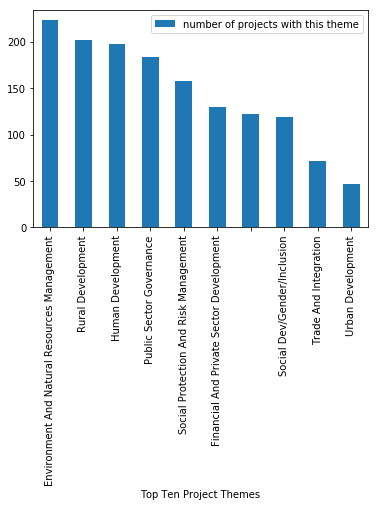

In [230]:
counter_frame = pd.DataFrame(c, columns=['Top Ten Project Themes', 'number of projects with this theme'])
counter_frame['Top Ten Project Themes'] = counter_frame['Top Ten Project Themes'].str.title()
counter_frame = counter_frame.set_index('Top Ten Project Themes')
counter_frame.plot(kind='bar')

## 3. In 2. above, some entries lack a theme name. This code repairs the data so that all values contain both a theme code and name.

The plot above reveals that a substantial number of entries have at least one empty name field:

In [231]:
df = json_df
# returns True if a name value is blank
df['mjtheme_namecode'].apply(lambda dict_list: '' in Counter([d['name'] for d in dict_list])).value_counts().head(10)

False    378
True     122
Name: mjtheme_namecode, dtype: int64

To fix the missing data, we need to be able to look up project themes by their codes. We can build a master dictionary of codes and project themes from the column in question:

In [232]:
master_theme_dict = {}

def build_theme_dict(list_of_dicts):
    for d in list_of_dicts:
        if d['code'] not in master_theme_dict and d['name'] != '':
            master_theme_dict[d['code']] = d['name']
                
df['mjtheme_namecode'].apply(build_theme_dict)

master_theme_dict

{'8': 'Human development',
 '1': 'Economic management',
 '6': 'Social protection and risk management',
 '5': 'Trade and integration',
 '2': 'Public sector governance',
 '11': 'Environment and natural resources management',
 '7': 'Social dev/gender/inclusion',
 '4': 'Financial and private sector development',
 '10': 'Rural development',
 '9': 'Urban development',
 '3': 'Rule of law'}

Then we use this dictionary to repair each column value. A first helper function repairs a missing value by looking it up in the master project theme dictionary:

In [233]:
def repair_missing_names_in_dict(the_dict):
    if the_dict['name'] == '':
        the_dict['name'] = master_theme_dict[the_dict['code']]
    return the_dict

And a second helper function applies the first to repair the dictionaries in each value of the column:

In [234]:
def fix_list_of_dicts(dict_list):
    for d in dict_list:
        repair_missing_names_in_dict(d)
    return dict_list

We then apply the helper function to the column for an in-place transformation using `map`.

In [235]:
df['mjtheme_namecode'] = df['mjtheme_namecode'].map(fix_list_of_dicts)

And now none of the values' dictionaries contain empty name fields:

In [236]:
# returns True if a name value is blank but now returns False for all values
df['mjtheme_namecode'].apply(lambda dict_list: '' in Counter([d['name'] for d in dict_list])).value_counts().head(10)

False    500
Name: mjtheme_namecode, dtype: int64

Now that the data have been repaired, the process from 2. produces plots without any unthemed projects:

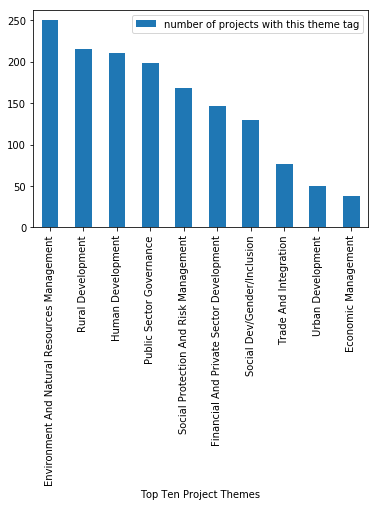

In [237]:
theme_name_list = [] # clear the global list
df['mjtheme_namecode'].apply(count_list_of_dicts)
c = Counter(theme_name_list).most_common(10)
counter_frame = pd.DataFrame(c, columns=['Top Ten Project Themes', 'number of projects with this theme tag'])
counter_frame['Top Ten Project Themes'] = counter_frame['Top Ten Project Themes'].str.title()
counter_frame = counter_frame.set_index('Top Ten Project Themes')
counter_frame.plot(kind='bar')

# But this would have been much easier with `json_normalize`!

## 1. What are the top ten countries doing projects?

This one is already a one-liner thanks to the `countrycode` field, so normalization isn't helping much.

## 2. What are the top ten project themes?:

This time, we normalize the JSON upon import to get a dataframe of the theme codes and names, and then we count values.

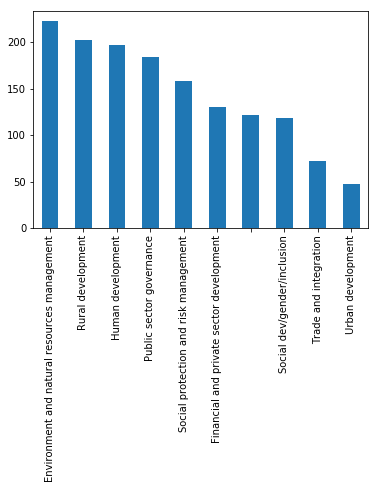

In [238]:
json_string = json.load(open('data/world_bank_projects.json'))
df = json_normalize(json_string, 'mjtheme_namecode')
df.name.value_counts().head(10).plot(kind='bar')

## 3. Repairing Missing Data

This still requires a dictionary of codes and some helper functions, but it's easier to build and to use. 

For one thing, it's much simpler to ask if there are missing names:

In [239]:
len(df[df.name == ''])

122

First, we build a master theme dictionary:

In [240]:
master_theme_dict = {}

def build_theme_dict(the_row):
    """Builds a master dictionary of theme codes (key) and names (value)."""
    if the_row['name']:
        master_theme_dict[the_row['code']] = the_row['name']
                
df.apply(build_theme_dict, axis=1)

master_theme_dict

{'8': 'Human development',
 '1': 'Economic management',
 '6': 'Social protection and risk management',
 '5': 'Trade and integration',
 '2': 'Public sector governance',
 '11': 'Environment and natural resources management',
 '7': 'Social dev/gender/inclusion',
 '4': 'Financial and private sector development',
 '10': 'Rural development',
 '9': 'Urban development',
 '3': 'Rule of law'}

And now we can repair the data in the table using the master dictionary.

In [241]:
def repair_name(row):
    """If a name is missing, look it up in the dictionary."""
    if row['name'] == '':
        row['name'] = master_theme_dict[row['code']] 
    return row

df.apply(repair_name, axis=1).head()

,code,name
0,8,Human development
1,11,Environment and natural resources management
2,1,Economic management
3,6,Social protection and risk management
4,5,Trade and integration


The table isn't missing any names now, and the plot no longer contains a column of unthemed projects.

In [242]:
len(df[df.name == ''])

0

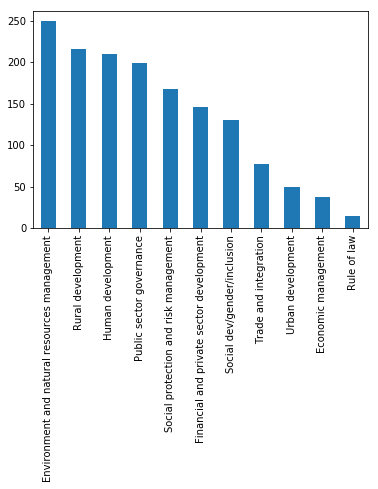

In [243]:
df.name.value_counts().plot(x='Top Ten Project Themes', y='number of projects of this theme',kind='bar')